In [3]:
import numpy as np
import numpy.fft as nf
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as sc
import time as time

I2 = qt.qeye(2)
Na = 3
Ia = qt.qeye(Na)

sm = qt.tensor(Ia, qt.sigmam())
sx = qt.tensor(Ia, qt.sigmax())
sz = qt.tensor(Ia, qt.sigmaz())
a  = qt.tensor(qt.destroy(Na), I2)
II = qt.tensor(Ia, I2)

vac = qt.tensor(qt.basis(Na,0), qt.basis(2,1))

options = qt.Options()
options.nsetps = 10000

def state(n, gnd_or_exc):
    if gnd_or_exc is 'exc':
        psi = a.dag()*vac
    elif gnd_or_exc is 'gnd':
        psi = vac
    else:
        raise ValueError('Poor state definition')
    for ii in range(n):
        psi = a.dag()*psi
    return psi

def H_gen(args):
    ''' Qubit + Cav + Transverse Coupling + Cav Drive '''
    H0 = args['w_qubit']*sz/2
    Ha = args['w_cav']*a.dag()*a
    Hc = args['g']*(a+a.dag())*sx
    H1 = a+a.dag()
    return [H0+Ha+Hc,[H1,H1_coeff]]

def H1_coeff(t, args):
    ''' Cosine drive '''
    return args['e_drive']*np.cos(args['w_drive']*t)
    
def D_gen(args):
    ''' Qubit + Cav relaxation '''
    return [[sm, D0_coeff], [a, Da_coeff]]
    
def D0_coeff(t, args):
    ''' Qubit relaxation '''
    return np.sqrt(args['gamma'])

def Da_coeff(t, args):
    ''' Cav relaxation '''
    return np.sqrt(args['kappa'])

def HRWA_gen(args, w_rwa='w_cav'):
    ''' RWA version of H_gen '''
    if w_rwa == 'w_cav':
        H0 = (args['w_qubit']-args['w_cav'])*sz/2
        Ha = 0*II
    elif w_rwa == 'w_qubit':
        H0 = 0*II
        Ha = (args['w_cav']-args['w_qubit'])*a.dag()*a
    Hc = args['g']*(a*sm.dag()+a.dag()*sm)
    H1 = a+a.dag()
    return [H0+Ha+Hc,[H1,H1_coeff]]

def w_larmor(args):
    ''' Larmor frequency '''
    e  = args['e_drive']
    wq = args['w_qubit']
    wd = args['w_drive']
    return np.sqrt(e**2+(wq-wd)**2)

def p_rabi(args):
    ''' Maximum excited probability for dissipation less system '''
    e  = args['e_drive']
    wq = args['w_qubit']
    wd = args['w_drive']
    return (e/w_larmor(args))**2

def gamma_purcell(args):
    return args['kappa']*args['g']**2/(args['kappa']**2/4+(args['w_qubit']-args['w_cav'])**2)

def func_cos(x, w, phi, A, C):
    return A*np.cos(w*x+phi)+C

def fit_cos(x, y, printing=False):
    ''' Use Fourier Transform to feed initial values to cosine fit '''
    y_mean = np.mean(y)
    y_fft  = nf.rfft(y-y_mean, norm='ortho')
    freqs  = nf.rfftfreq(len(x), x[1]-x[0])
    i_gues = np.argmax(np.abs(y_fft))
    w_gues = 2*np.pi*freqs[i_gues]
    p_gues = np.pi*(1-np.sign(np.real(y_fft[i_gues])))/2
    A_gues = (np.max(y) - np.min(y))/2
    p0     = [w_gues, p_gues, A_gues, y_mean]
    popt, pcov = sc.curve_fit(func_cos, x, y, p0=p0)
    if printing:
        print('guess: ', np.round(p0,3))
        print('fit:   ', np.round(popt,3))
        print('------------------------')
    return popt, pcov

def func_lor(x, x0, gamma, A):
    return A/(1+((x-x0)*2/gamma)**2)

def func_double_lor(x, x0, gamma, A, g):
    return A*(1/(1+((x-x0-g)*2/gamma)**2)+1/(1+((x-x0+g)*2/gamma)**2))

def absorption_spectrum(args, N=11, sp=3, nmax=5000, printing=False):
    ''' Generate the absorption spectrum of the Qubit for N drives '''
    ''' centered around w_qubit with span +/- sp*gamma '''
    
    H     = H_gen(args)
    psi0  = vac
    D     = [[sm,D0_coeff]]
    obs   = [sm*sm.dag()]
    gamaP = gamma_purcell(args)
    
    if args['gamma'] < 2*args['e_drive']:
        print('Power broadening')

    # Construction of the time list:
    # Crucially one must resolve the drive frequency according to Shannon criteria,
    # which sets 'tstep'. Ideally the slow dynamics should also be captured, which
    # sets 'tmax', but the number of points is limited to 'nmax'
    if g > max(args['gamma'], 2*args['e_drive']):
        wfast = g*sp
    else:
        wfast = max(args['gamma'], gamaP, 2*args['e_drive'])*sp
    wdriv = np.linspace(args['w_qubit']-wfast, args['w_qubit']+wfast, N)
    tstep = 2*np.pi/(2*wdriv[-1])
    wslow = args['gamma']
    tmax  = 2*np.pi/wslow
    n     = min(2*int(tmax/tstep), nmax)
    times = np.linspace(0, n*tstep, n+1)
    freqs = nf.rfftfreq(len(times), times[1]-times[0])
    
    alert = 0
    if n is nmax:
        alert = 1
    print(n, 'bins:', end='')
    start = time.time()
    
    s_abs = np.zeros(N)
    for ii, wd in enumerate(wdriv):
        startloop = time.time()
        args['w_drive'] = wd
        result    = qt.mesolve(H, psi0, times, D, obs, args=args, options=options)  
        smsp_fft  = nf.rfft(result.expect[0], norm='ortho')
        ii_wd     = np.argmin(np.abs(freqs-wd/2/np.pi))
        s_abs[ii] = np.abs(smsp_fft[ii_wd])
        if printing and ii in [int(N/4), int(N/2)]:
            fig, ax = plt.subplots(1,2, figsize=(12,4))
            ax[0].plot(times, result.expect[0])
            ax[0].set_ylabel(r'$<\sigma_-\sigma_+>$')
            ax[0].grid(linestyle='--')
            ax[1].plot(freqs[:], np.abs(smsp_fft[:]))
            ax[1].plot(freqs[ii_wd], np.abs(smsp_fft[ii_wd]), 'o')
            ax[1].set_ylabel(r'|TF $[<\sigma_-\sigma_+>]$|')
            ax[1].grid(linestyle='--')
            ax[1].set_ylim([np.abs(smsp_fft[ii_wd])*(-0.1),np.abs(smsp_fft[ii_wd])*20])
            fig.suptitle(printer(args))

    if alert:
        print(' ', np.round(time.time()-start,1),'s - nmax reached ', str(2*int(tmax/tstep)))
    else:
        print(' ', np.round(time.time()-start,1),'s')
            
    return wdriv, s_abs/np.max(s_abs)

def printer(args):
    pargs = {}
    largs = {'w_qubit':r'$\omega_q$', 'w_cav':r'$\omega_c$', 'w_drive':r'$\omega_d$',
             'e_drive':r'$\varepsilon_d$', 'gamma':r'$\gamma$', 'kappa':r'$\kappa$', 'g':r'$g$'}
    title = ''
    for keys in args.keys():
        pargs[keys] = args[keys]/2/np.pi
        title += largs[keys]+'=%.2f,  '%pargs[keys]
    return title

4812 bins:  172.3 s
4812 bins:  195.7 s
4812 bins:  152.2 s
4824 bins:  158.5 s
4848 bins:  184.2 s
done


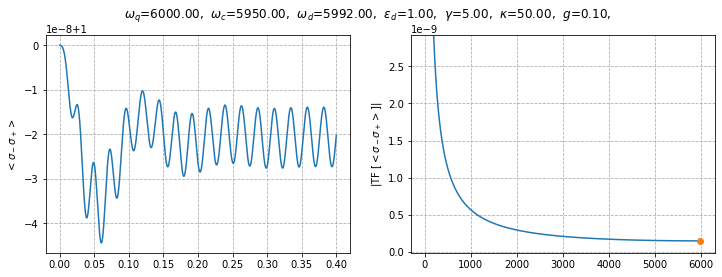

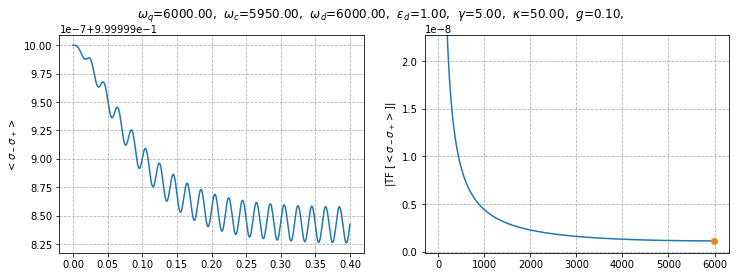

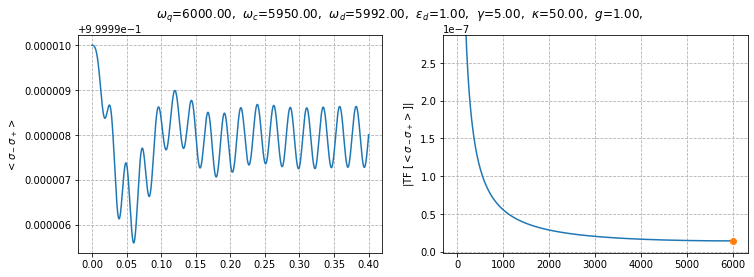

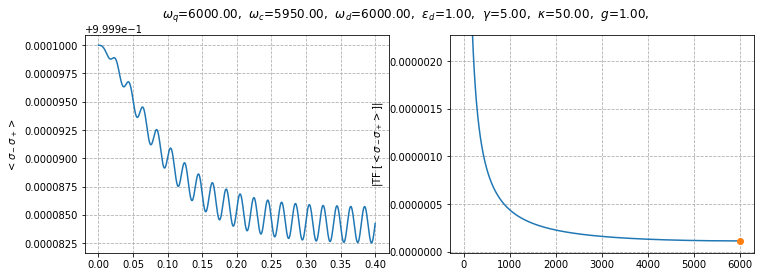

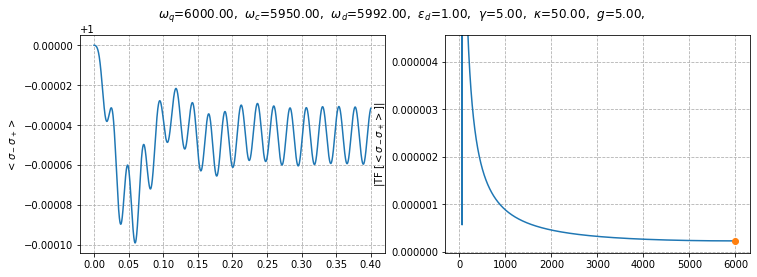

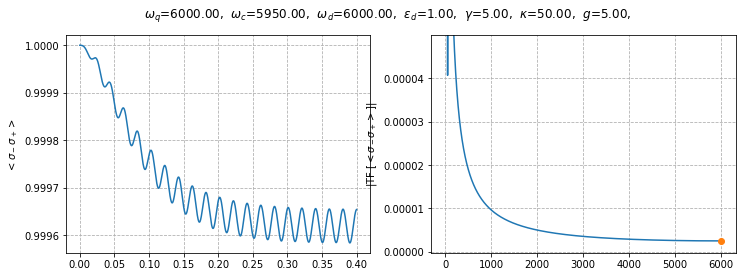

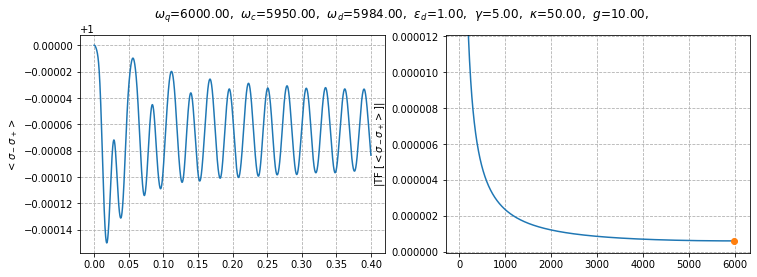

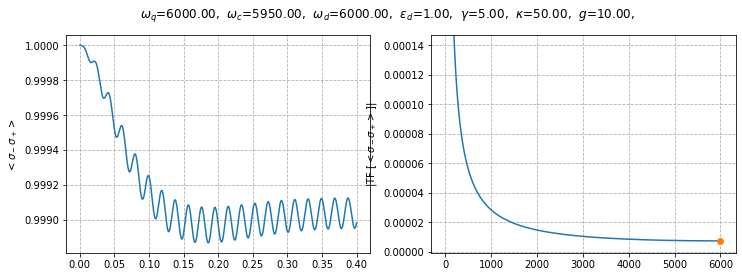

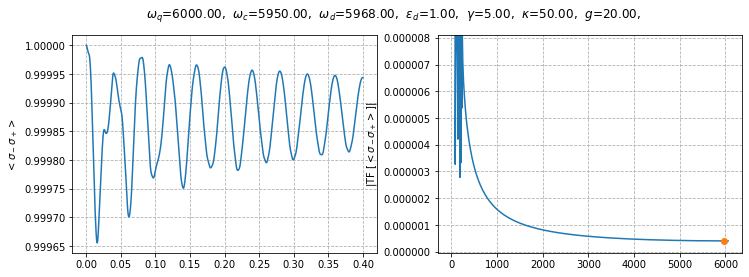

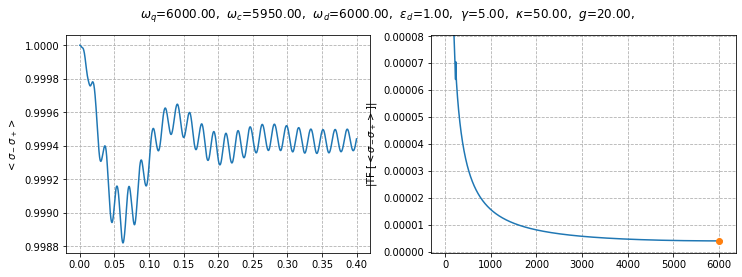

In [4]:
''' Purcell effect '''

wqbit = 2*np.pi*6000
wcav  = wqbit
wdriv = wqbit
edriv = 2*np.pi*1e0
gamma = 2*np.pi*5e0
kappa = 2*np.pi*5e1
glist = 2*np.pi*np.array([0.1, 1, 5, 10, 20])
wcav -= 2*np.pi*5e1

printing = True
wdriv_list, s_abs_list = [],[]
for ii, g in enumerate(glist):
    args  = {'w_qubit':wqbit, 'w_cav':wcav, 'w_drive':wdriv, 'e_drive':edriv,
             'gamma':gamma, 'kappa':kappa, 'g':g}
    wdriv, s_abs = absorption_spectrum(args, N=31, printing=printing)
    wdriv_list.append(wdriv)
    s_abs_list.append(s_abs)
print('done')


Text(0.5, 0, '$(g/2\\pi)^2$')

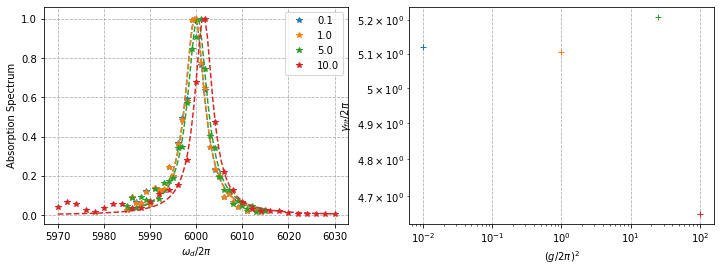

In [5]:
''' Plotting '''

fig, ax = plt.subplots(1,2, figsize=(12,4))
for ii, g in enumerate(glist[:-1]):
    wdriv = wdriv_list[ii]
    s_abs = s_abs_list[ii]
    guess = np.sqrt(gamma**2 + gamma_purcell(args))
    popt, pcov = sc.curve_fit(func_lor, wdriv, s_abs, p0=[wqbit,guess,1])
    wdriv_th = np.linspace(wdriv[0], wdriv[-1], 101)
    ax[0].plot(wdriv/2/np.pi, s_abs, '*', label='%.1f'%(g/2/np.pi), color='C'+str(ii))
    ax[0].plot(wdriv_th/2/np.pi, func_lor(wdriv_th,*popt), '--', color='C'+str(ii))
    ax[1].loglog((g/2/np.pi)**2, popt[1]/2/np.pi, '+')
ax[0].set_ylabel(r'Absorption Spectrum')
ax[0].grid(linestyle='--')
ax[0].set_xlabel(r'$\omega_d/2\pi$')
ax[0].legend()
ax[1].set_ylabel(r'$\gamma_{fit}/2\pi$')
ax[1].grid(linestyle='--')
ax[1].set_xlabel(r'$(g/2\pi)^2$')

4808 bins:  268.1 s
4830 bins:  170.1 s
4816 bins:  178.7 s
4830 bins:  214.0 s
4864 bins:  194.8 s
done


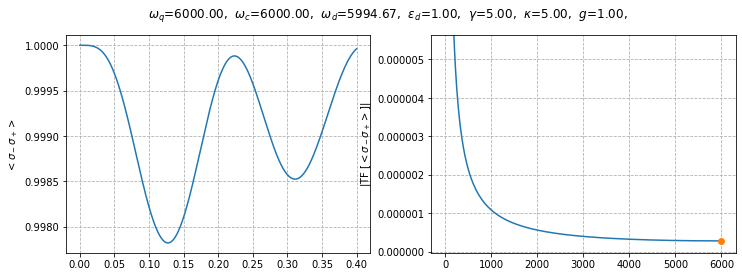

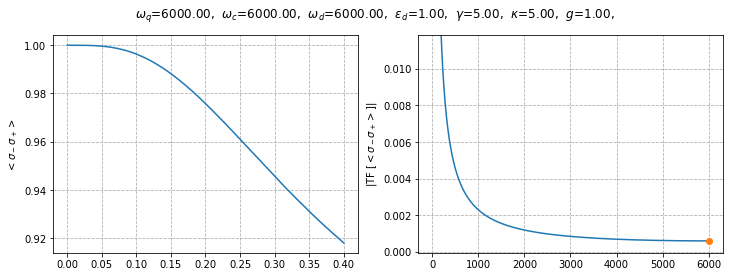

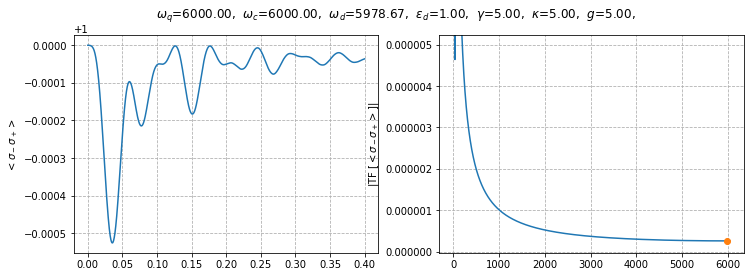

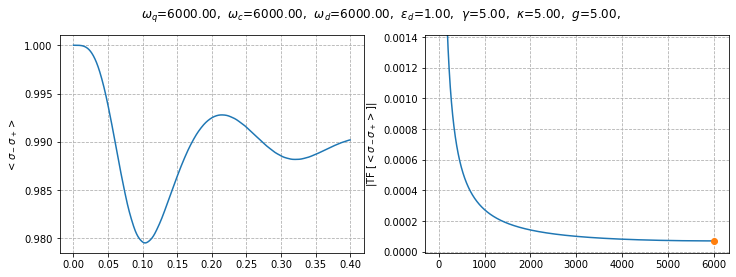

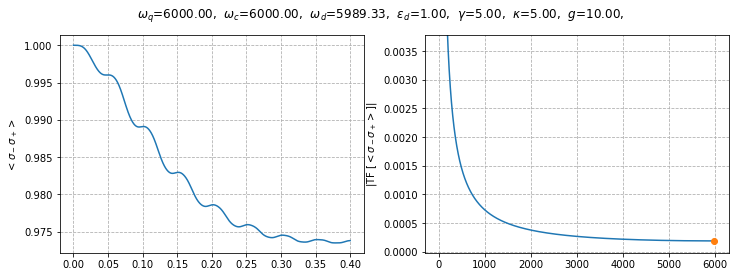

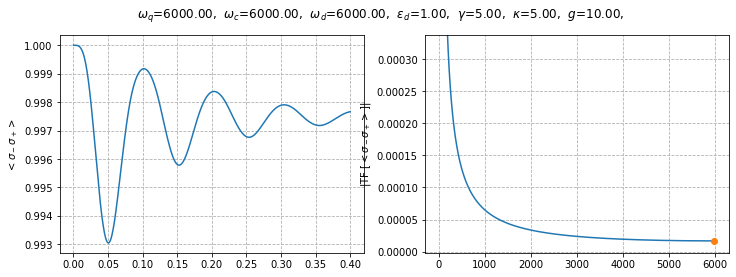

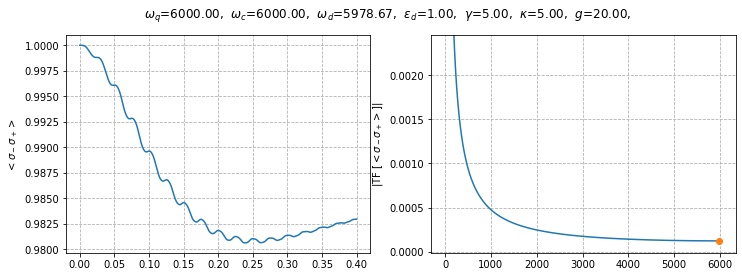

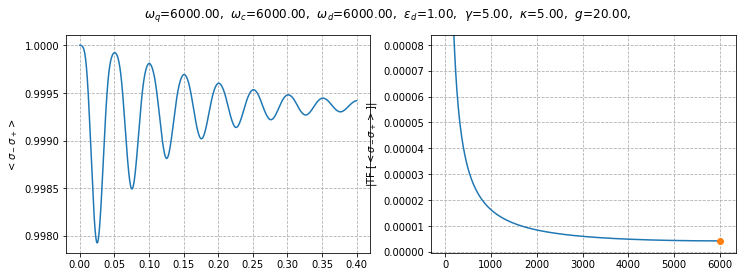

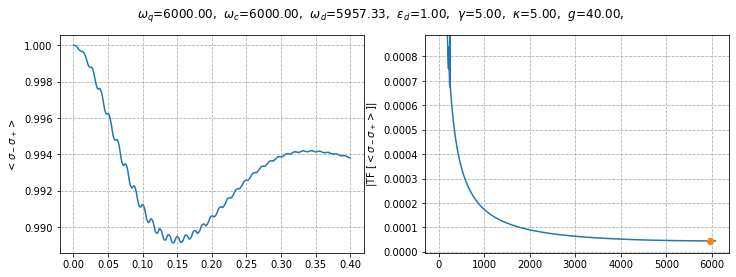

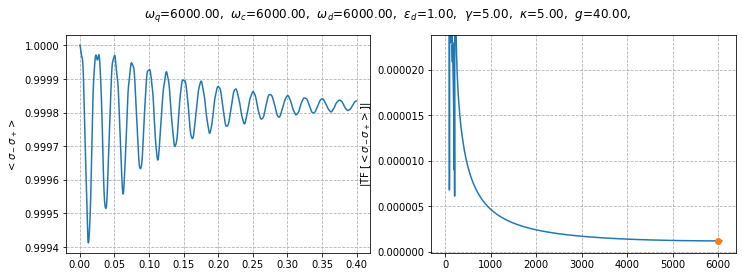

In [6]:
''' Vacuum Rabi Splitting   '''

wqbit = 2*np.pi*6000
wcav  = wqbit
wdriv = wqbit
edriv = 2*np.pi*1e0
gamma = 2*np.pi*5e0
kappa = 2*np.pi*5e0
glist = 2*np.pi*np.array([1,5,10,20,40])

printing = True
wdriv_list, s_abs_list = [],[]
for ii, g in enumerate(glist):
    args  = {'w_qubit':wqbit, 'w_cav':wcav, 'w_drive':wdriv, 'e_drive':edriv,
             'gamma':gamma, 'kappa':kappa, 'g':g}
    wdriv, s_abs = absorption_spectrum(args, N=31, sp=2, printing=printing)
    wdriv_list.append(wdriv)
    s_abs_list.append(s_abs)
print('done')


In [ ]:
''' Plotting '''

fig, ax = plt.subplots(1,2, figsize=(12,4))
for ii, g in enumerate(glist[:]):
    wdriv = wdriv_list[ii]
    s_abs = s_abs_list[ii]
    popt, pcov = sc.curve_fit(func_double_lor, wdriv, s_abs, p0=[wqbit,gamma,1,g])
    wdriv_th = np.linspace(wdriv[0], wdriv[-1], 101)
    ax[0].plot(wdriv/2/np.pi, s_abs/popt[2], '*', label='%.1f'%(g/2/np.pi), color='C'+str(ii))
    ax[0].plot(wdriv_th/2/np.pi, func_double_lor(wdriv_th,*popt)/popt[2], '--', color='C'+str(ii))
    ax[1].plot(g/2/np.pi, popt[3]/2/np.pi, '+')
ax[0].set_ylabel(r'Absorption Spectrum')
ax[0].grid(linestyle='--')
ax[0].set_xlabel(r'$\omega_d/2\pi$')
ax[0].legend()
ax[1].set_ylabel(r'$g_{fit}/2\pi$')
ax[1].grid(linestyle='--')
ax[1].set_xlabel(r'$g/2\pi$')

Text(0.5, 0, '$g/2\\pi$')

elapsed time =  2.4795989990234375


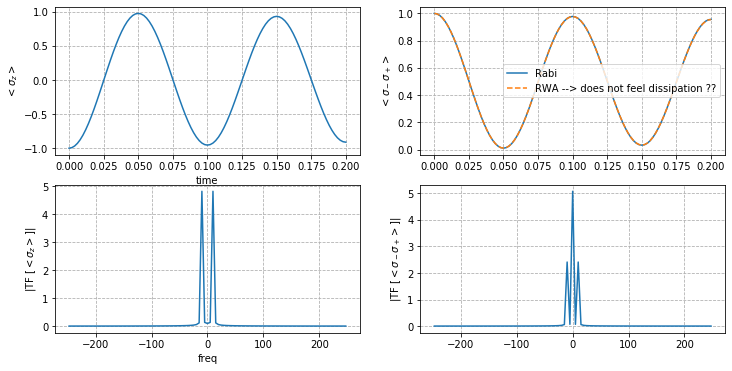

In [19]:
''' Test cell - Time & Frequency visualisation'''

wqbit = 2*np.pi*6000
wdriv = wqbit
edriv = 2*np.pi*1e1
gamma = 2*np.pi*1e-1

options = qt.Options()
options.nsetps = 10000

args  = {'w_qubit':wqbit, 'w_drive':wdriv, 'e_drive':edriv, 'gamma':gamma}
psi0  = gnd
times = np.linspace(0,0.2,101)
D     = [[sm,D0_coeff]]
obs   = [sz, sm*sm.dag()]

start = time.time()
H = H_gen(args)
result = qt.mesolve(H, psi0, times, D, obs, args=args, options=options) 
H_rwa = HRWA_gen(args)
result_rwa = qt.mesolve(H_rwa, psi0, times, D, obs, args=args, options=options) 
print('elapsed time = ', time.time()-start)

sz_fft   = nf.fftshift(nf.fft(result.expect[0], norm='ortho'))
smsp_fft = nf.fftshift(nf.fft(result.expect[1], norm='ortho'))
freqs    = nf.fftshift(nf.fftfreq(len(times), times[1]-times[0]))

fig, ax = plt.subplots(2,2, figsize=(12,6))
ax[0,0].plot(times, result.expect[0], '-')
ax[0,0].set_ylabel(r'$<\sigma_z>$')
ax[0,0].grid(linestyle='--')
ax[0,0].set_xlabel('time')
ax[1,0].plot(freqs, np.abs(sz_fft))
ax[1,0].set_ylabel(r'|TF $[<\sigma_z>]$|')
ax[1,0].set_xlabel('freq')
ax[1,0].grid(linestyle='--')
ax[0,1].plot(times, result.expect[1], label='Rabi ')
ax[0,1].plot(times, result_rwa.expect[1], '--', label='RWA --> does not feel dissipation ??')
ax[0,1].legend()
ax[0,1].set_ylabel(r'$<\sigma_-\sigma_+>$')
ax[0,1].grid(linestyle='--')
ax[1,1].plot(freqs[:], np.abs(smsp_fft[:]))
ax[1,1].set_ylabel(r'|TF $[<\sigma_-\sigma_+>]$|')
ax[1,1].grid(linestyle='--')
#ax[1,1].set_ylim([0,0.2])


In [3]:
dic = {a:2, b:3}

NameError: name 'b' is not defined

In [ ]:
dic

In [33]:
a = '%.g zob'%(2)

In [34]:
a

'2 zob'